# Lab 6 - Eliot Harrell - Analyze New Hampshire Census Data With AI

## Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

Collect NH (fips = 33) Data in SQL and Add to Dataframe

In [3]:
sql = """
     select * from name_income
     where fips = '33'
     """

In [4]:
import pandas as pd

nh_df = pd.read_sql(sql, con=conn)
nh_df.head() #show the top 5 rows

/tmp/ipykernel_15169/1349906867.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nh_df = pd.read_sql(sql, con=conn)


,fips,name,income,year
0,33,New Hampshire,56768,2005
1,33,New Hampshire,59683,2006
2,33,New Hampshire,62369,2007
3,33,New Hampshire,63731,2008
4,33,New Hampshire,60567,2009


### Install AI Assistants

In [5]:
! pip install jupyter-ai-magics[all] -q

In [6]:
import warnings
warnings.simplefilter('ignore')

In [7]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [8]:
%load_ext jupyter_ai_magics

In [9]:
%%ai gpt4
What is included in the {nh_df}

The given data includes the following information:

- FIPS code: This is an identifier code, specifically the Federal Information Processing Standard publication 6-4 code, for geographic areas in United States. In this dataset, the code '33' is used, which represents the state of New Hampshire.
  
- Name: This is the name of the geographic area. In this dataset, it's "New Hampshire."

- Income: This represents the income earned in a specific year within the geographic area denoted by the FIPS code. The values are presumably given in US dollars.

- Year: This represents the year for which the income is recorded. The dataset includes annual data from 2005 to 2019.

Here is a demo of the data in table format:

| FIPS  |       NAME     |   INCOME  |  YEAR |
| :---   |            :---:   |   :---:         |    :---:   |
|33    | New Hampshire | 56768 | 2005 |
|33    |  New Hampshire | 59683 | 2006 |
|33    |  New Hampshire | 62369 | 2007 |
|33    |  New Hampshire | 63731 | 2008 |
|33    |  New Hampshire | 60567 | 2009 |
|33    |  New Hampshire | 61042 | 2010 |
|33    |  New Hampshire | 62647 | 2011 |
|33    |  New Hampshire | 63280 | 2012 |
|33    |  New Hampshire | 64230 | 2013 |
|33    |  New Hampshire | 66532 | 2014 |
|33    |  New Hampshire | 70303 | 2015 |
|33    |  New Hampshire | 70936 | 2016 |
|33    |  New Hampshire | 73381 | 2017 |
|33    |  New Hampshire | 74991 | 2018 |
|33    |  New Hampshire | 77933 | 2019 |

In [10]:
import pandas as pd

# Execute the SQL command using cursor `cur`
cur.execute("SELECT * FROM name_income")

# Fetch all rows from the last executed statement using `fetchall()` method
data = cur.fetchall()

# Get the column names for the data
column_names = [desc[0] for desc in cur.description]

# Convert the data into DataFrame
df = pd.DataFrame(data, columns = column_names)


### Q1: Using AI to generate the population growth chart

SQL query to get population data per year in NH:

In [11]:
query = f"""
SELECT 
    p.year,
    p.pop AS population,
    ROUND(
        100.0 * (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) / LAG(p.pop) OVER (ORDER BY p.year),
        2
    ) AS growth_rate_percent
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'New Hampshire'
ORDER BY p.year;
"""

In [12]:
%%ai gpt4 -f code
using the query from {In[11]} and the connection information from {In[2]}, DO NOT redefine the query (simply use it as is), and the previous information about the cursor and connection, make a line graph that displays the population growth rate per year in new hampshire
include the state name in the title. do not close the connection.

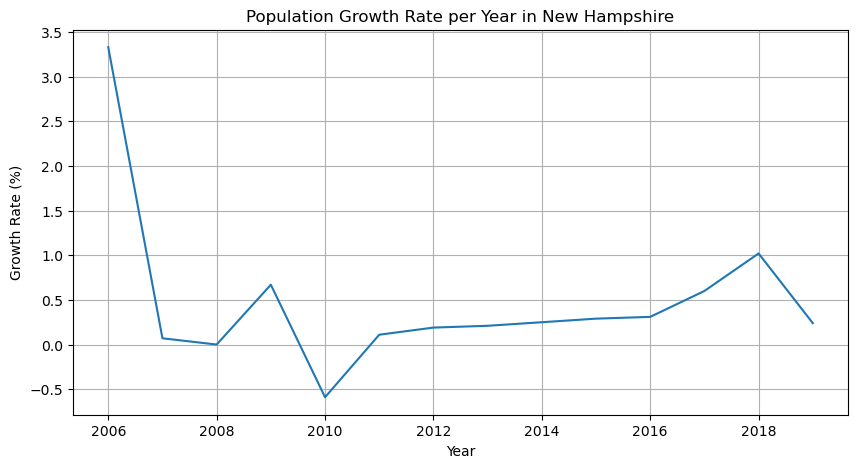

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# execute the SQL query
cur.execute(query)

# fetch all rows from cursor
data = cur.fetchall()

# convert data to pandas DataFrame
df = pd.DataFrame(data, columns=['year', 'population', 'growth_rate_percent'])

# Plotting
plt.figure(figsize=[10,5])
plt.plot(df['year'], df['growth_rate_percent'])
plt.title('Population Growth Rate per Year in New Hampshire')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid()
plt.show()


The above graph shows the rate of population growth (and decline) between 2005 and 2019. We can see an initial decline, an anomalous spike and dip between 2008 and 2010, and then a steady rise followed by a dropoff in 2019.

### Q2: Using AI to create a dual-axis chart for NH population and income

SQL query to create a joined table of populaiton, year, and income for New Hampshire:

In [14]:
query = f"""
SELECT 
    p.year,
    p.pop AS population,
    i.income
FROM population p
JOIN income i 
    ON p.fips = i.fips 
    AND p.year = i.year
JOIN name n 
    ON p.fips = n.fips
WHERE n.name = 'New Hampshire'
ORDER BY p.year;
"""

In [15]:
%%ai gpt4 -f code
using the query from {In[14]} (DO NOT REDEFINE THE QUERY) and the connection information from {In[2]}, create a dual axis chart.
X-axis = year
Left Y-axis = population (line)
Right Y-axis = median household income (different color)
include the State Name (New Hampshire) in the title, and do not close the connection.

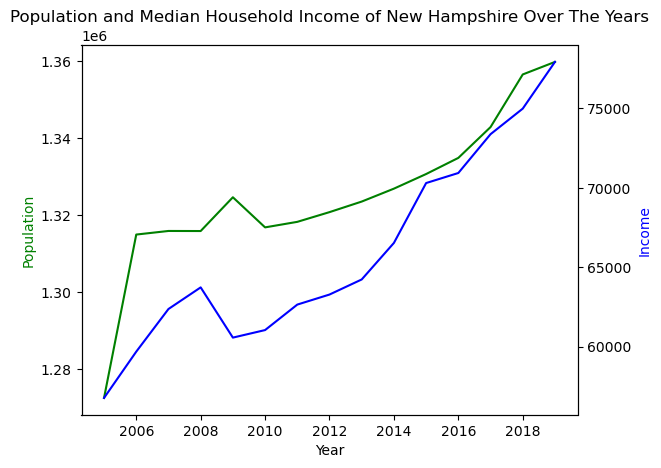

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# execute the SQL query
cur.execute(query)

# fetch all rows from cursor
data = cur.fetchall()

# convert data to pandas DataFrame
df = pd.DataFrame(data, columns=['year', 'population', 'income'])

# create figure and axis objects
fig, ax1 = plt.subplots()

# make a plot with different y-axis using second axis object
ax2 = ax1.twinx()
ax1.plot(df['year'], df['population'], color='g')
ax2.plot(df['year'], df['income'], color='b')

# set labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='g')
ax2.set_ylabel('Income', color='b')
plt.title('Population and Median Household Income of New Hampshire Over The Years')

# display the plot
plt.show()


The above graph shows the contrast between the rate of income increase and the rate of population increase. At the beginning of the time-series, the population grew significantly faster than income, but in recent years, income has caught up, growing at nearly the same rate. Between 2008 and 2009, both metrics spiked significantly.

### Q3: Custom Question: Using AI to generate an income-per-capita graph for New Hampshire

Since I want to use income-per-capita, I can use the same query from the last question because it has all the necessary data.

In [17]:
%%ai gpt4 -f code
Using the query from {In[14]} (DO NOT REDEFINE THE QUERY) and the connection information from {In[2]}, create code for a bar chart that shows
the income per capita of new hampshire by year. Include the state name in the title, and do not close the connection.

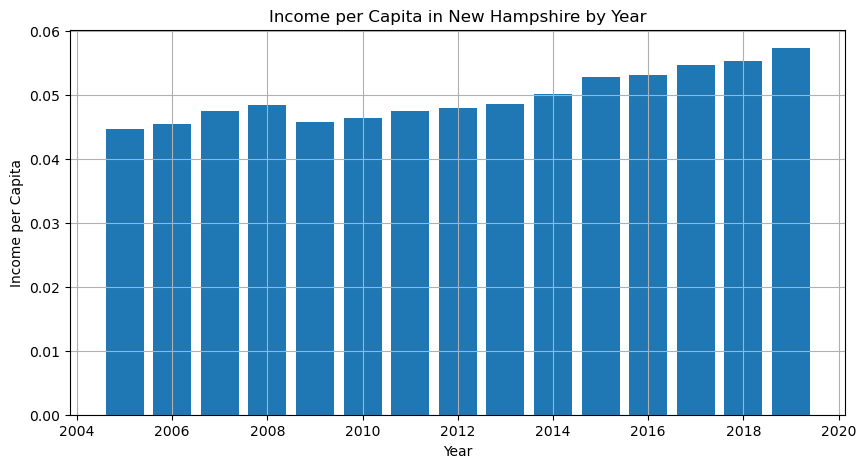

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# execute the SQL query
cur.execute(query)

# fetch all rows from cursor
data = cur.fetchall()

# convert data to pandas DataFrame
df = pd.DataFrame(data, columns=['year', 'population', 'income'])

# calculate income per capita
df['income_per_capita'] = df['income'] / df['population']

# Creating bar chart
plt.figure(figsize=[10,5])
plt.bar(df['year'], df['income_per_capita'])
plt.xlabel('Year')
plt.ylabel('Income per Capita')
plt.title('Income per Capita in New Hampshire by Year')
plt.grid()
plt.show()

The above bar chart displays the per-capita income (income divided by population) for each year. While largely remaining steady, there has been a slight increase between 2005 and 2019. Once again, there was a spike around 2008. This has been a trend across every visualization.

Close the connection and cursor:

In [19]:
cur.close()
conn.close()